In [1]:
# General imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import normalize

# Neurophox imports
from neurophox.numpy import RMNumpy
from neurophox.tensorflow import RM
from neurophox.ml.nonlinearities import cnorm, cnormsq

### Preprocessing

In [3]:
# Import dataset
(X_raw, y), (X_test_raw, y_test) = mnist.load_data()

# # Reshape each entry from 2D images into 1D arrays
# X = X_raw.reshape(X_raw.shape[0], X_raw.shape[1]*X_raw.shape[2])
# X_test = X_test_raw.reshape(X_test_raw.shape[0], X_test_raw.shape[1]*X_test_raw.shape[2])

# # Scaling
# X = (X / 255).astype(np.complex64)
# X_test = (X_test / 255).astype(np.complex64)

In [4]:
# FTing the image data
X_ft = np.fft.fftshift(np.fft.fft2(X_raw), axes=(1, 2))
X_test_ft = np.fft.fftshift(np.fft.fft2(X_test_raw), axes=(1, 2))

# Cropping out the outer pixels
X_ft = X_ft[:, 10:18, 10:18]
X_test_ft = X_test_ft[:, 10:18, 10:18]

# Flatten image
X_ft = X_ft.reshape(X_ft.shape[0], -1)
X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], -1)

# Normalizing
X_ft = normalize(np.abs(X_ft), axis=1, norm='l1').astype(np.complex64)
X_test_ft = normalize(np.abs(X_test_ft), axis=1, norm='l1').astype(np.complex64)

In [5]:
X_ft.shape

(60000, 64)

In [6]:
# One-Hot encoding the labels
y = to_categorical(y)
y_test = to_categorical(y_test)

### Modelling

Activation function formula:

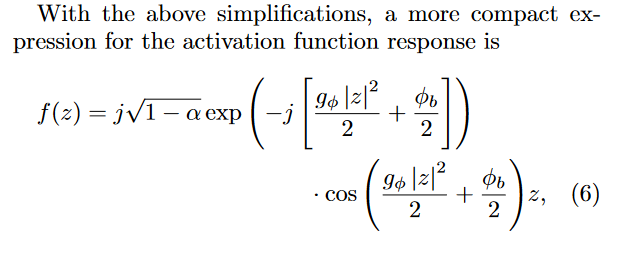

In [7]:
class EOIntensityModulation(tf.keras.layers.Layer):
    def __init__(self, N, alpha=0.1, g=np.pi, phi_b=np.pi, train_alpha=False, train_g=False, train_phi_b=False, single_param_per_layer=True):
        
        super(EOIntensityModulation, self).__init__()
        
        if single_param_per_layer:
            var_shape = [1]
        else:
            var_shape = [N]
        
        self.g = self.add_variable(shape=var_shape,
                                       name="g",
                                       initializer=tf.constant_initializer(g),
                                       trainable=train_g,
                                       constraint=lambda x: tf.clip_by_value(x, 1e-3, 1.5*np.pi))
        self.phi_b = self.add_variable(shape=var_shape,
                                       name="phi_b",
                                       initializer=tf.constant_initializer(phi_b),
                                       trainable=train_phi_b,
                                       constraint=lambda x: tf.clip_by_value(x, -np.pi, +np.pi))
        self.alpha = self.add_variable(shape=var_shape,
                                       name="alpha",
                                       initializer=tf.constant_initializer(alpha),
                                       trainable=train_alpha,
                                       constraint=lambda x: tf.clip_by_value(x, 0.01, 0.99))
    
    def call(self, inputs):
        alpha, g, phi_b = tf.complex(self.alpha, 0.0), tf.complex(self.g, 0.0), tf.complex(self.phi_b, 0.0)
        Z = inputs
        return 1j * tf.sqrt(1-alpha) * tf.exp(-1j*0.5*g*tf.math.conj(Z)*Z - 1j*0.5*phi_b) * tf.cos(0.5*g*tf.math.conj(Z)*Z + 0.5*phi_b) * Z

The procedure is summarised well by the following diagram.

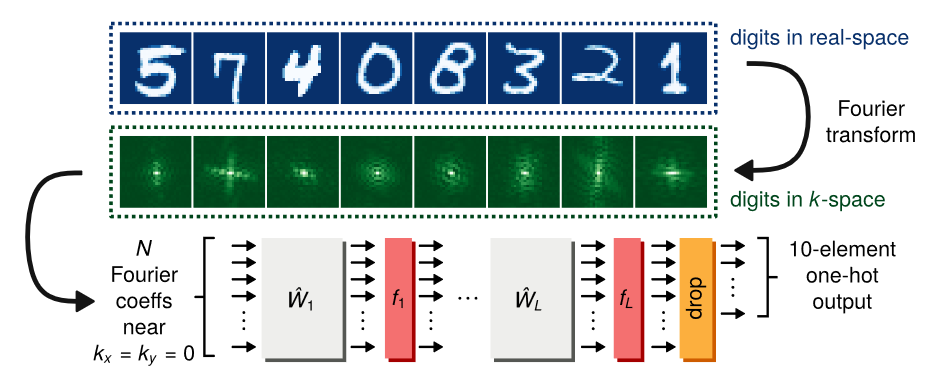

To get a better idea of the network layers -

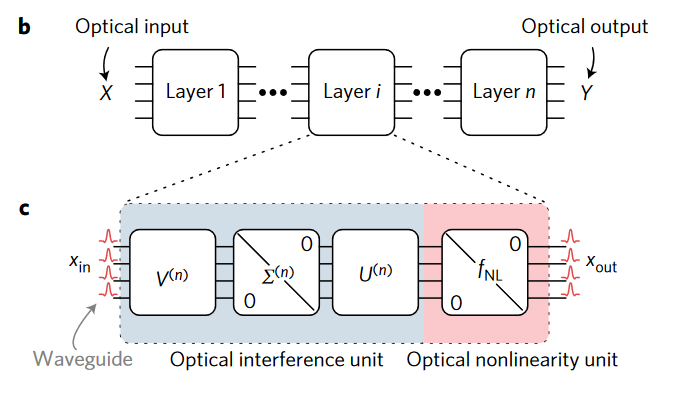

In [11]:
def generate_network(N, N_classes=10, L=1, theta_init_name='haar_rect', phi_init_name='random_phi', alpha=0.1, g=0.05*np.pi, phi_b=1*np.pi):
    """ Creates L layer ONN

    Args:
        N (_type_): _description_
        N_classes (int, optional): _description_. Defaults to 10.
        L (int, optional): _description_. Defaults to 1.
        theta_init_name (str, optional): _description_. Defaults to 'haar_rect'.
        phi_init_name (str, optional): _description_. Defaults to 'random_phi'.

    Returns:
        Sequential: _description_
    """
    layers=[]
    
    for _ in range(0, L):
        layers.append(RM(N, theta_init_name=theta_init_name, phi_init_name=phi_init_name))
        layers.append(EOIntensityModulation(N, alpha, g, phi_b))
    
    layers.append(Activation(cnorm))
    layers.append(Lambda(lambda x: tf.math.real(x[:, :N_classes])))
    layers.append(Lambda(lambda x: tf.math.l2_normalize(x, axis=-1)))
    
    return Sequential(layers)

In [ ]:
epochs = 20
batch_size = 512
N_classes = 10

onn_model = generate_network(64, L=2)
onn_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = onn_model.fit(X_ft, y, epochs=epochs, batch_size=batch_size, validation_data=(X_test_ft, y_test), verbose=2)

Epoch 1/20
118/118 - 49s - loss: 1.6916 - accuracy: 0.5593 - val_loss: 1.4143 - val_accuracy: 0.7094 - 49s/epoch - 414ms/step
Epoch 2/20
118/118 - 24s - loss: 1.3447 - accuracy: 0.7230 - val_loss: 1.2691 - val_accuracy: 0.7511 - 24s/epoch - 200ms/step
Epoch 3/20
118/118 - 23s - loss: 1.2539 - accuracy: 0.7445 - val_loss: 1.2090 - val_accuracy: 0.7628 - 23s/epoch - 198ms/step
Epoch 4/20
118/118 - 24s - loss: 1.1920 - accuracy: 0.7571 - val_loss: 1.1562 - val_accuracy: 0.7710 - 24s/epoch - 200ms/step
Epoch 5/20
118/118 - 28s - loss: 1.1500 - accuracy: 0.7648 - val_loss: 1.1209 - val_accuracy: 0.7798 - 28s/epoch - 239ms/step
Epoch 6/20
118/118 - 21s - loss: 1.1131 - accuracy: 0.7703 - val_loss: 1.0836 - val_accuracy: 0.7810 - 21s/epoch - 182ms/step
Epoch 7/20
118/118 - 21s - loss: 1.0820 - accuracy: 0.7765 - val_loss: 1.0533 - val_accuracy: 0.7882 - 21s/epoch - 182ms/step
Epoch 8/20
118/118 - 26s - loss: 1.0490 - accuracy: 0.7814 - val_loss: 1.0213 - val_accuracy: 0.7950 - 26s/epoch - 224

-----------------------------------------------------
### Playing around with mesh layers

In [12]:
tf_layer = RM(8) # Implicitly sets the number of MZI 'layers' to N when not specified.

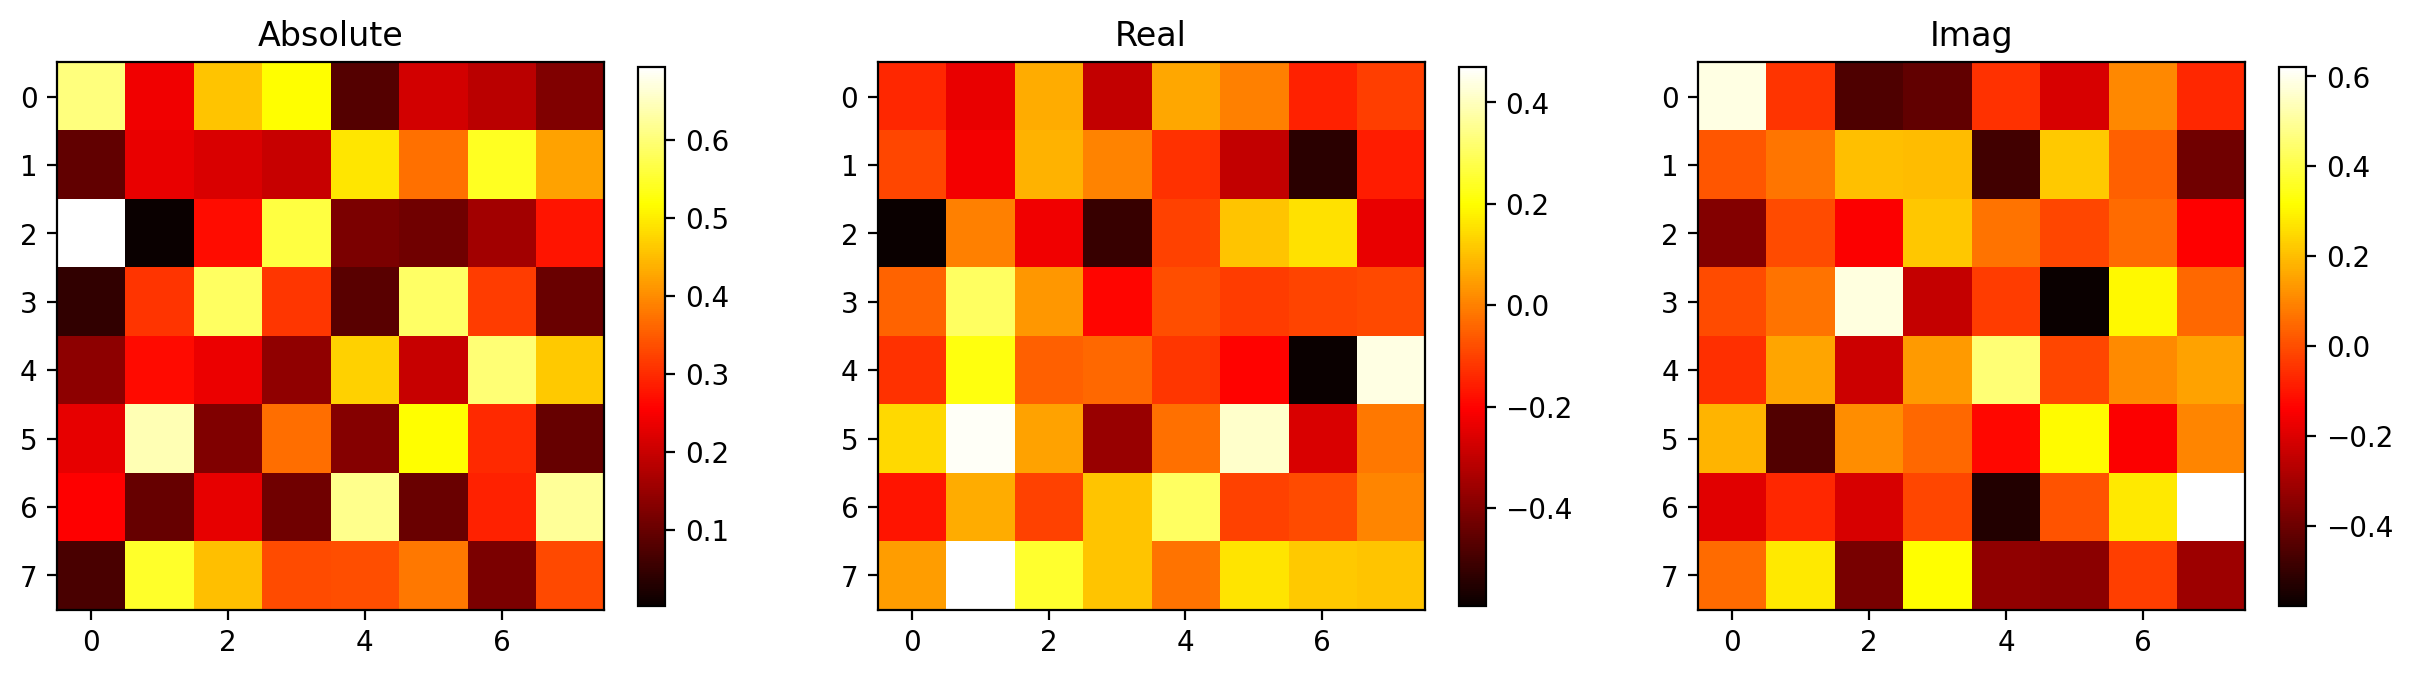

In [21]:
tf_layer.plot(plt)